In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Input, Lambda, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [2]:
import torch
import torch.nn as nn

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"divyanshijoshi","key":"4cf4ad7341cdc5b961f91df3dd74a735"}'}

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [5]:
!kaggle datasets download -d shadmanrohan/collisionavoidancechallenge

Dataset URL: https://www.kaggle.com/datasets/shadmanrohan/collisionavoidancechallenge
License(s): unknown
 99% 106M/107M [00:01<00:00, 131MB/s] 
100% 107M/107M [00:01<00:00, 108MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('collisionavoidancechallenge.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
train_data= pd.read_csv('/content/train_data.csv')
test_data= pd.read_csv('/content/test_data.csv')

In [8]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.3 MB/s eta 0:00:00


In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import missingno

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, fbeta_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder

from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam

In [10]:
df = pd.read_csv("/content/train_data.csv")
#features_ = ["risk"] #Array!! Time features that you want to analyze
timestep = 8 #from 1 to 23 (17 with the current NaN strategy)
fill_X = -0.01
threshold_for_classification = -6.5
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
seed = 11

#CNN hiperparameter
epochs = 50
batch = 64
val_split = 0.25
test_split = 0.25
lr = 0.0001
adam = optimizers.Nadam(learning_rate=0.001) #(lr)
class_weight = {True:  100.,
                False: 1.}
verbose = 1



In [11]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 2 or max_tca < 2
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<2.0) & (x.max()>2.0))

df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
df["mission_id"] = df["mission_id"].astype('category')
df["c_object_type"] = df["c_object_type"].astype('category')
df = pd.get_dummies(df)

#Getting y as 1D-array
y_original = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)

#Scaling y
_ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #using the whole risk feature to scale the target 'y'
y = y_scaler.transform(y_original)

#Getting X as df (dropping rows with tca < 2)
df = df.loc[df["time_to_tca"]>2]

#Adding feature 'event_length' for counting how many instances each event has
df['event_length'] = df.groupby('event_id')['event_id'].transform('count')

#Scaling X
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

#Transforming X into a 3D-array
events = df["event_id"].nunique() #rows
features = len(df.columns) #columns
X = np.zeros((events,timestep,features))
X.fill(fill_X)
i = 0

def df_to_3darray(event):
    global X, i
    #Transforming an event to time series (1,timesteps, columns)
    row = event.values.reshape(1,event.shape[0],event.shape[1])
    #Condition is needed to slice arrays correctly
    #Condition -> is timestep greater than the event's time series length?
    if(timestep>=row.shape[1]):
        X[i:i+1,-row.shape[1]:,:] = row
    else:
        X[i:i+1,:,:] = row[:,-timestep:,:]
    #index to iterate over X array
    i = i + 1
    #dataframe remains intact, while X array has been filled.
    return event

df.groupby("event_id").apply(df_to_3darray)

#Dropping event_id to remove noise
X = X[:,:,1:]

#Reshaping again to 2D array but now events are filled
X = X.reshape(X.shape[0], timestep*X.shape[2])

#Naming shifted columns
shifted_columns = []
original_columns = list(df.columns)[1:] #Dropping event_id

for step in range(timestep-1,-1,-1):
    for column in original_columns:
        shifted_columns.append(column+"_t-"+str(step))

#Creating df from reshape array and shifted column names
X = pd.DataFrame(X, columns=shifted_columns)
display(X)

#Getting last value for evaluation
last_risk_index = shifted_columns.index("risk_t-0")

#Reshaping X to add channels for Conv1D
X = X.to_numpy().reshape(X.shape[0],X.shape[1],1)

print(X.shape, y.shape)

<ipython-input-11-c269579987c3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_length'] = df.groupby('event_id')['event_id'].transform('count')


time_to_tca_t-7  risk_t-7  max_risk_estimate_t-7  max_risk_scaling_t-7  \
0            0.606686  0.000000               0.404379          8.614638e-06   
1            0.516181  0.000000               0.272028          4.214210e-06   
2            0.550833  0.903156               0.663666          1.524790e-08   
3            0.464432  0.041265               0.577087          2.850849e-06   
4            0.525578  0.823186               0.448510          1.680284e-07   
...               ...       ...                    ...                   ...   
7306         0.480712  0.775480               0.355151          2.423005e-07   
7307         0.464364  0.000000               0.453411          6.547600e-06   
7308        -0.010000 -0.010000              -0.010000         -1.000000e-02   
7309         0.494159  0.000000               0.329546          1.378482e-05   
7310         0.504029  0.806517               0.537027          3.310156e-07   

      miss_distance_t-7  relative_speed_t-7  relative_position_r_t-7  \
0              0.280699            0.842595                 0.439864   
1              0.368149            0.797042                 0.552023   
2              0.004735            0.115033                 0.534372   
3              0.167419            0.588013                 0.552668   
4              0.080072            0.717131                 0.586849   
...                 ...                 ...                      ...   
7306           0.370821            0.780600                 0.637996   
7307           0.049537            0.605870                 0.510281   
7308          -0.010000           -0.010000                -0.010000   
7309           0.373850            0.065237                 0.377442   
7310           0.033994            0.879663                 0.473136   

      relative_position_t_t-7  relative_position_n_t-7  \
0                    0.460358                 0.678152   
1                    0.621473                 0.720590   
2                    0.510633                 0.499532   
3                    0.426965                 0.426705   
4                    0.545602                 0.543352   
...                       ...                      ...   
7306                 0.639294                 0.713752   
7307                 0.539249                 0.477748   
7308                -0.010000                -0.010000   
7309                 0.255615                 0.514310   
7310                 0.512270                 0.477934   

      relative_velocity_r_t-7  relative_velocity_t_t-7  \
0                    0.474211                 0.181552   
1                    0.460626                 0.267332   
2                    0.470727                 0.965273   
3                    0.472842                 0.596096   
4                    0.478615                 0.399198   
...                       ...                      ...   
7306                 0.465328                 0.308295   
7307                 0.467319                 0.574670   
7308                -0.010000                -0.010000   
7309                 0.503496                 0.976609   
7310                 0.469210                 0.115158   

      relative_velocity_n_t-7  t_time_lastob_start_t-7  t_time_lastob_end_t-7  \
0                    0.303619                     0.00                   0.00   
1                    0.785983                     0.00                   0.00   
2                    0.599800                     0.00                   0.00   
3                    0.875560                     0.00                   0.00   
4                    0.848355                     0.00                   0.00   
...                       ...                      ...                    ...   
7306                 0.824375                     0.00                   0.00   
7307                 0.122545                     0.00                   0.00   
7308                -0.010000                    -0.01   

(7311, 992, 1) (7311, 1)


In [12]:
#computing scaled threshold
th = np.array([threshold_for_classification]).reshape(-1,1)
th = y_scaler.transform(th)
threshold_scaled = th[0,0]

#Splitting arrays
y_boolean = (y > threshold_scaled).reshape(-1,1)
X_train, X_test, y_train_numeric, y_test_numeric = train_test_split(X, y,
                                                    stratify=y_boolean,
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = test_split
                                                  )

y_train_boolean = (y_train_numeric > threshold_scaled).reshape(-1,1)
X_train, X_val, y_train_numeric, y_val_numeric = train_test_split(X_train, y_train_numeric,
                                                    stratify=y_train_boolean,
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = val_split
                                                  )
#transforming it into a classification task -> y_train, y_test boolean
y_train = (y_train_numeric > threshold_scaled).reshape(-1,1)
y_val = (y_val_numeric > threshold_scaled).reshape(-1,1)
y_test = (y_test_numeric > threshold_scaled).reshape(-1,1)

#Percentage of high risks in train
print("TRAIN {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_train), y_train.shape[0], np.sum(y_train)/y_train.shape[0]))
#Percentage of high risks in val
print("VAL   {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_val), y_val.shape[0], np.sum(y_val)/y_val.shape[0]))
#Percentage of high risks in test
print("TEST  {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_test), y_test.shape[0], np.sum(y_test)/y_test.shape[0]))

TRAIN 73.0, 4112.0, 0.018
VAL   24.0, 1371.0, 0.018
TEST  33.0, 1828.0, 0.018


In [13]:
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

In [14]:
model = Sequential([
    Conv1D(10, 8, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(10, 8, activation='relu'),
    MaxPooling1D(6),
    #Dropout(0.5),
    Conv1D(20, 8, activation='relu'),
    Conv1D(20, 8, activation='relu'),
    MaxPooling1D(6),
    #Dropout(0.5),

    Flatten(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

adam = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()


# Train the model
model_history = model.fit(X_train, y_train,
                          epochs=80,
                          batch_size=64,
                          shuffle=True,
                          validation_data=(X_val, y_val),
                          verbose=verbose,
                          class_weight=class_weight).history


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 985, 10)           90        
                                                                 
 conv1d_1 (Conv1D)           (None, 978, 10)           810       
                                                                 
 max_pooling1d (MaxPooling1  (None, 163, 10)           0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 156, 20)           1620      
                                                                 
 conv1d_3 (Conv1D)           (None, 149, 20)           3220      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 24, 20)            0         
 g1D)                                                   

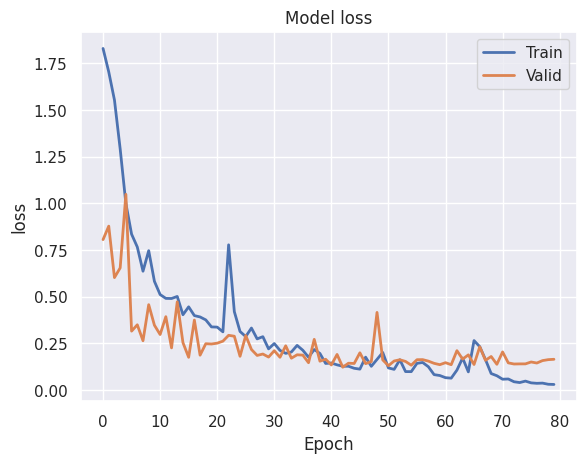

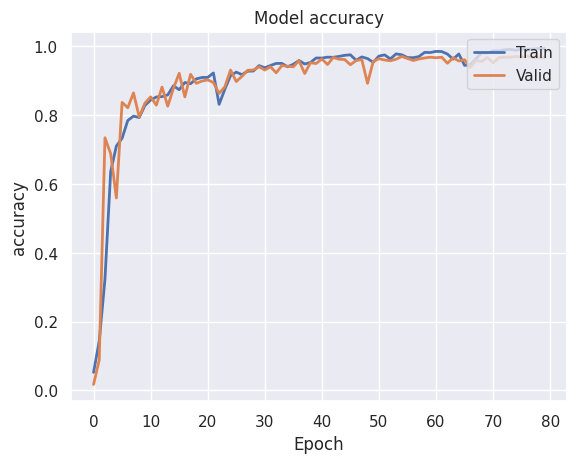

In [15]:
sns.set()

for graph in ['loss', 'accuracy']:

    plt.plot(model_history[graph], linewidth=2, label='Train')
    plt.plot(model_history['val_'+graph], linewidth=2, label='Valid')

    plt.legend(loc='upper right')
    plt.title('Model '+graph)
    plt.ylabel(graph)
    plt.xlabel('Epoch')

    plt.show()

In [16]:
print("Training accuracy:", model_history['accuracy'][-1] * 100, '%')
print("Validation accuracy:", model_history['val_accuracy'][-1] * 100, '%')


Training accuracy: 99.4163453578949 %
Validation accuracy: 96.71772718429565 %


29/29 [==============================] - 0s 11ms/step


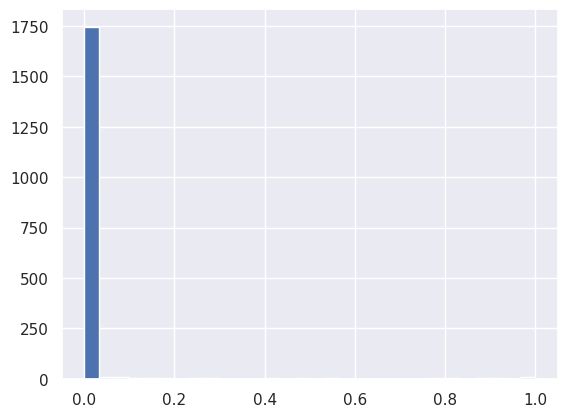

LSTM model: 4.913, 0.819, 0.167


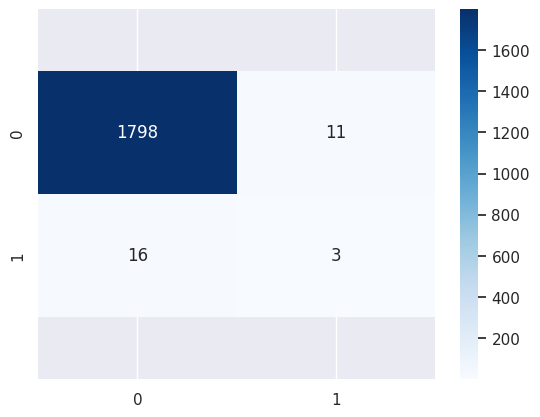

Constant prediction: 6.819, 0.340, 0.050


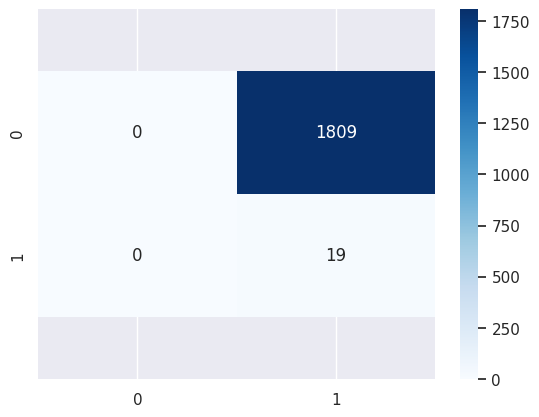

Predicting last value: 0.600, 0.372, 0.620


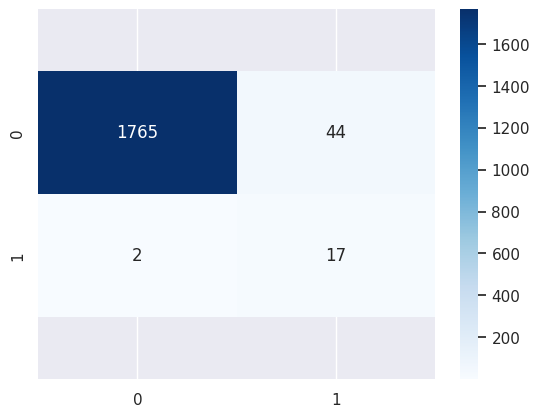

In [17]:
from sklearn.metrics import fbeta_score

#Model Evaluation
high_risk_real_value = -5.0
low_risk_real_value = -6.0001
classification_threshold = 0.914

def evaluate(name, y_pred):

    # Rescaling data
    y_test_scaled = y_scaler.inverse_transform(y_test_numeric)

    # Getting numeric predictions from boolean predictions
    y_pred_numeric = np.zeros((y_pred.shape[0], y_pred.shape[1]))
    y_pred_numeric[y_pred==True] = high_risk_real_value
    y_pred_numeric[y_pred==False] = low_risk_real_value

    # Getting predictions greater than -6.0 in real data (y_test_scaled)
    y_pred_mse = y_pred_numeric[np.where(y_test_scaled >= -6.0)]
    y_test_mse = y_test_scaled[np.where(y_test_scaled >= -6.0)]

    mse = mean_squared_error(y_test_mse, y_pred_mse)

    y_real_bool = (y_test_scaled >= -6.0).reshape(-1, 1)

    # Calculating F-beta score with beta=2
    f_beta = fbeta_score(y_real_bool, y_pred, beta=2)
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))

    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred), annot=True, cmap="Blues", fmt='d')
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

# Predicting with model
y_model = model.predict(X_test, batch_size=batch)
plt.hist(y_model, bins=30)
plt.show()
y_model = (y_model > classification_threshold).reshape(-1, 1)
evaluate("LSTM model:", y_model)

# Predicting -5 always
y_constant = np.ones((y_test.shape[0], y_test.shape[1]), dtype=bool)
evaluate("Constant prediction:", y_constant)

# Predicting last value
y_last = X_test[:, last_risk_index, 0]
tmp = np.array([-6]).reshape(-1, 1)
tmp = y_scaler.transform(tmp)
tmp = tmp[0, 0]
y_last = (y_last >= tmp).reshape(-1, 1)
evaluate("Predicting last value:", y_last)


Predicting last value: 15.029, 9.324, 0.620


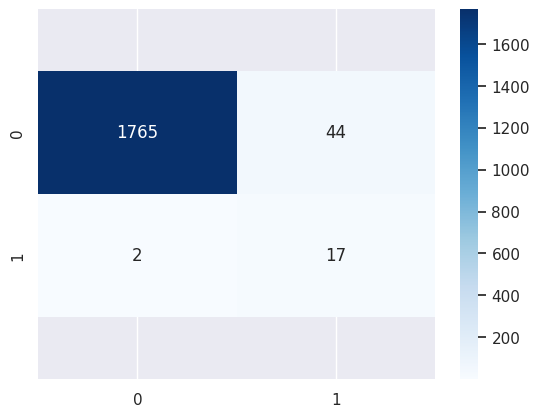

In [18]:
from sklearn.metrics import fbeta_score

#Predicting last value
def recurrent_evaluate(name, y_pred):

    # Scaling both real predicted
    y_pred_scaled = y_scaler.inverse_transform(y_pred)
    y_real_scaled = y_scaler.inverse_transform(y_test_numeric)

    # Boolean data
    y_pred_bool = (y_pred_scaled >= -6.0).reshape(-1, 1)
    y_real_bool = (y_real_scaled >= -6.0).reshape(-1, 1)

    # Calculating F-beta score with beta=2
    f_beta = fbeta_score(y_real_bool, y_pred_bool, beta=2)

    # Getting predictions greater than -6.0 in real data (y_real_scaled)
    y_pred_mse = y_pred_scaled[np.where(y_real_scaled >= -6.0)]
    y_real_mse = y_real_scaled[np.where(y_real_scaled >= -6.0)]
    mse = mean_squared_error(y_real_mse, y_pred_mse)

    # F-beta score
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))

    # Confusion matrix
    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred_bool), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

    return y_pred_bool

y_last = X_test[:,last_risk_index,0].reshape(-1,1)
y_bool_2 = recurrent_evaluate("Predicting last value:", y_last)
